# 📢Step1 Practice
* 작성일: 2023-09-17
* 작성자: 박준영
* 관련스텝: Step1
* 마크다운 Latex문법 참고: https://cheris8.github.io/etc/MD-LaTex/

## 📌Embedding 이해하기(코드 실습)

### 🍔완전 랜덤으로 차원축소

|| Item1 | Item2 | Item3 |
|---| :-: | :-: | :-: |
|User1| 5 | 4 | 0 |
|User2| 0 | 5 | 3 |
|User3| 4 | 0 | 5 |

In [1]:
import numpy as np

# User-Item interaction matrix (e.g., ratings)
# Rows represent users, and columns represent items
interaction_matrix = np.array([
    [5, 4, 0],
    [0, 5, 3],
    [4, 0, 5]
])
print(interaction_matrix.shape)
num_users, num_items = interaction_matrix.shape
embedding_dim = 2  # The dimension of user and item embeddings

# Initialize user and item embeddings randomly
user_embeddings = np.random.rand(num_users, embedding_dim)
item_embeddings = np.random.rand(num_items, embedding_dim)


(3, 3)


In [2]:
print(f"유저임베딩{user_embeddings}, 아이템임베딩{item_embeddings}")

유저임베딩[[0.96156378 0.71840101]
 [0.15457761 0.05576603]
 [0.32303992 0.94424001]], 아이템임베딩[[0.46526247 0.93974007]
 [0.92549892 0.99387225]
 [0.97037503 0.04818468]]


### 🍔np.dot(DotProduct) 사용해서 차원축소

#### 🍟np.dot이란? 실습으로 알아보기
* $(1 \times 4) + (2 \times 5) + (3 \times 6) = 32$

In [3]:
import numpy as np

array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])

result = np.dot(array1, array2)

print(result)  # 출력: 32


32


#### 🍟차원축소하는 알고리즘(np.dot사용됨)

In [4]:
def matrix_factorization(interaction_matrix, user_embeddings, item_embeddings, embedding_dim, learning_rate=0.01, num_iterations=100):
    for _ in range(num_iterations):
        for i in range(num_users):
            for j in range(num_items):
                if interaction_matrix[i, j] > 0:
                    error_ij = interaction_matrix[i, j] - np.dot(user_embeddings[i], item_embeddings[j]) 
                    #print(f"i:{i} j:{j} error: {error_ij}")
                    for k in range(embedding_dim):
                        user_embeddings[i][k] += learning_rate * (1.5 * error_ij * item_embeddings[j][k])
                        item_embeddings[j][k] += learning_rate * (2 * error_ij * user_embeddings[i][k])
    return user_embeddings, item_embeddings

# Perform matrix factorization
user_embeddings2, item_embeddings2 = matrix_factorization(interaction_matrix, user_embeddings, item_embeddings, embedding_dim)


In [5]:
print(f"유저임베딩{user_embeddings2}, 아이템임베딩{item_embeddings2}")

유저임베딩[[0.87247868 1.72058999]
 [1.31301883 1.12046695]
 [1.83026615 1.15335326]], 아이템임베딩[[1.03210525 2.13822956]
 [2.21473022 1.41819168]
 [1.75391399 1.1839674 ]]


---

## 📌light-GCN 실습
* 주의할 점: 이 실습은 output 없는(추론) 캐글 소스코드이다.
* 그러므로, Adjacency matrix로 프로젝트를 하기위해 추론 과정을 임의로 넣어서 실험 진행했음.

In [6]:
import torch
torch.__version__

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.13.1'

In [7]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

### 🍔데이터셋 unzip

In [8]:
#! rm -r /step1/input

In [9]:
! unzip /step1/archive.zip -d /step1/input

Archive:  /step1/archive.zip
  inflating: /step1/input/ml-100k/README  
  inflating: /step1/input/ml-100k/allbut.pl  
  inflating: /step1/input/ml-100k/mku.sh  
  inflating: /step1/input/ml-100k/u.data  
  inflating: /step1/input/ml-100k/u.genre  
  inflating: /step1/input/ml-100k/u.info  
  inflating: /step1/input/ml-100k/u.item  
  inflating: /step1/input/ml-100k/u.occupation  
  inflating: /step1/input/ml-100k/u.user  
  inflating: /step1/input/ml-100k/u1.base  
  inflating: /step1/input/ml-100k/u1.test  
  inflating: /step1/input/ml-100k/u2.base  
  inflating: /step1/input/ml-100k/u2.test  
  inflating: /step1/input/ml-100k/u3.base  
  inflating: /step1/input/ml-100k/u3.test  
  inflating: /step1/input/ml-100k/u4.base  
  inflating: /step1/input/ml-100k/u4.test  
  inflating: /step1/input/ml-100k/u5.base  
  inflating: /step1/input/ml-100k/u5.test  
  inflating: /step1/input/ml-100k/ua.base  
  inflating: /step1/input/ml-100k/ua.test  
  inflating: /step1/input/ml-100k/ub.base  
  

In [10]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("/step1/input/ml-100k/u.data",sep="\t",names=columns_name)
print(len(df))
display(df.tail(5))
unique_ratings = df['rating'].unique()
unique_ratings.sort()
print(f"🍰rating 범위: {unique_ratings}")

100000


,user_id,item_id,rating,timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


🍰rating 범위: [1 2 3 4 5]


In [11]:
df['user_id'].max(), df['item_id'].max()

(943, 1682)

### 🍔긍정평가를 3점이상으로 정해보자

In [12]:
df = df[df['rating']>=3]
print(len(df))

82520


In [13]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    27145
4    34174
5    21201
Name: rating, dtype: int64

### 🍔train_test_split

In [14]:
train, test = train_test_split(df.values, test_size=0.2, random_state = 16)
train = pd.DataFrame(train, columns = df.columns)
test = pd.DataFrame(test, columns = df.columns)
print("Train Size  : ", len(train))
print("Test Size : ", len (test))

Train Size  :  66016
Test Size :  16504


In [15]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['item_id_idx'] = le_item.fit_transform(train['item_id'].values)

train_user_ids = train['user_id'].unique()
train_item_ids = train['item_id'].unique()


test = test[(test['user_id'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['item_id_idx'] = le_item.transform(test['item_id'].values)

print(f"train['user_id']: {len(train['user_id'])}개")
print(f"train_user_ids: {len(train_user_ids)}개 , train_item_ids: {len(train_item_ids)}개 ⬅ unique적용")
print(f"test: {len(test)}개")

train['user_id']: 66016개
train_user_ids: 943개 , train_item_ids: 1546개 ⬅ unique적용
test: 16472개


In [16]:
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1546


### 🍔latent 차원과 layer 수 설정
* latent dimension: length of the user/item embedding 임베딩 길이
* layers: number of times we want to propagate our initial user/item embedding through the graph
* 그래프를 통해 초기 사용자/아이템 임베딩을 전파할 횟수입니다.

In [17]:
latent_dim = 64
n_layers = 3

### 🍔[scipy ➡ Pytorch] Sparse Matrix 만들기(Dictionary of Keys) 
* Sparse Matrix: 희소행렬(원핫인코더 느낌?)
* "Sparse matrix" VS "Adjacency matrix"
* Adjacency matrix 참고자료: https://sarah950716.tistory.com/12
* dok : Dictionary of Keys
* coo : Coordinate(좌표계)

* $ SparseMatrix = \begin{vmatrix} 0 & 0 & 0 & 7\\ 9 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 6 & 5 & 0 & 0  \end{vmatrix} $
* $ Adjacency matrix = \begin{vmatrix} 0 & 1 & 1 & 1\\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0  \end{vmatrix} $

#### 🍟핵심: SparseMatrix, Adjacencymatrix는 개념만 명확히 알고 있다면, 수작업으로 직접 알고리즘 만들 수 있다.
* 다만, 컴퓨터 자원문제로 인접리스트(STL vector) 등을 사용한다.
* https://sarah950716.tistory.com/4 ⬅ c++ 언어라서 파이썬 cmake 등을 사용해야 할텐데, 우리는 그럴 시간이 없다.
* ChatGPT4(KHJ) 또는 검색을 통해 이미 만들어진 알고리즘 사용하자.. 아니면 우리가 찾은 git 코드분석해서 그대로 쓰는 방법도 있다.

In [18]:
def convert_to_sparse_tensor(dok_mtrx):
    
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

### 🍔precision, recall, NDCG, MAP 구하는 메서드

In [19]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    relevance_score = relevance_score+R_tensor_dense

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
 
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean() 

### 🍔모델
* get_A_tilda: 사용자 - 항목 상호작용 그래프에 대한 정규화된 adjacency matrix 생성
  * 21줄 scipy Dictionary of Keys

In [20]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)
        
        # Below Code is toconvert the dok_matrix to sparse tensor.
        
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor
    
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [21]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)
lightGCN

LightGCN(
  (E0): Embedding(2489, 64)
)

### 🍔Loss 메서드
* reg_loss: 정규화 손실을 계산. L2 노름(제곱)을 계산. 이 정규화 항은 큰 임베딩을 갖는 모델에 불이익을 주어 과적합을 방지하는 데 도움이 됩니다.
* pos_scores, neg_scores: 양수 및 음수 샘플에 대한 점수를 계산합니다.

In [22]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
  
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + 
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
        
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
        
    return loss, reg_loss

### 🍔Data_loader
* 사용자를 샘플링하고 각 사용자에 대해 사용자가 학습 데이터에서 상호작용한 포지티브 항목 1개와 상호작용하지 않은 네거티브 항목 1개를 샘플링.

In [23]:
def data_loader(data, batch_size, n_usr, n_itm):
  
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id
  
    indices = [x for x in range(n_usr)]
    
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
  
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
  
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [24]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

In [25]:
EPOCHS = 30
BATCH_SIZE = 1024 
DECAY = 0.0001
K = 10

### 🍔Training Loop

In [26]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = [] 

for epoch in tqdm(range(EPOCHS)):
    n_batch = int(len(train)/BATCH_SIZE)
  
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
  
    best_ndcg = -1
  
    train_start_time = time.time()
    lightGCN.train()
    for batch_idx in range(n_batch):

        optimizer.zero_grad()

        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss

        final_loss.backward()
        optimizer.step()

        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    lightGCN.eval()
    with torch.no_grad():
    
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    if test_topK_ndcg > best_ndcg:
        best_ndcg = test_topK_ndcg
      
        torch.save(final_user_Embed, 'final_user_Embed.pt')
        torch.save(final_item_Embed, 'final_item_Embed.pt')
        torch.save(initial_user_Embed, 'initial_user_Embed.pt')
        torch.save(initial_item_Embed, 'initial_item_Embed.pt')
     

    eval_time = time.time() - train_end_time

    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)  

100%|██████████| 30/30 [00:55<00:00,  1.84s/it]


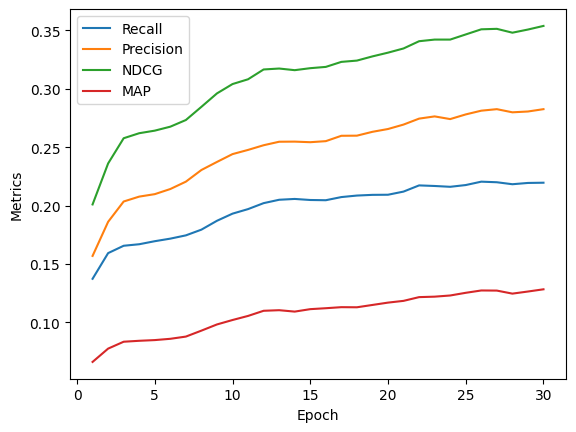

In [27]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

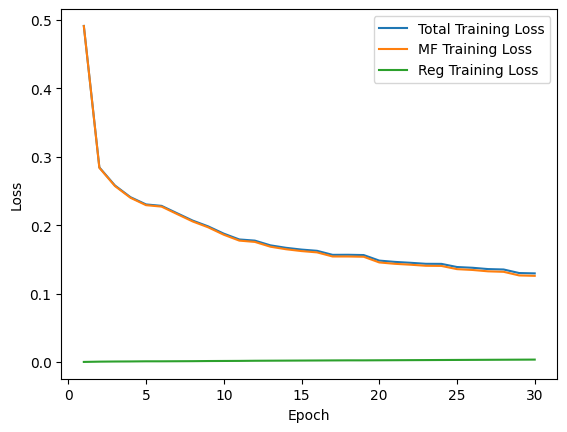

In [28]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [29]:
print("Averge time taken to train an epoch -> ", round(np.mean(train_time_list),2), " seconds")
print("Averge time taken to eval an epoch -> ", round(np.mean(eval_time_list),2), " seconds")

Averge time taken to train an epoch ->  1.76  seconds
Averge time taken to eval an epoch ->  0.08  seconds


In [30]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.2196
Last Epoch's Test Data Precision ->  0.2826
Last Epoch's Test Data NDCG ->  0.3539
Last Epoch's Test Data MAP ->  0.1283
Last Epoch's Train Data Loss ->  0.1296


### 🍔추론(아래는 개인적으로 실험 중인 것으로, 추후 adjacency 행렬로 작업을 할 때를 대비하는 것)
* 현재 추론 할 때 인덱스 에러가 뜰 수 있는데, 몇 번 실행하다보면 됩니다..

In [41]:
# 데이터셋 로드 및 전처리 (데이터셋 구조에 따라 수정해야 함)
data2 = {
    'user_id_idx': np.random.randint(n_users, size=500),
    'item_id_idx': np.random.randint(n_items, size=500),
    'rating': np.random.randint(1, 6, size=500),
    'timestamp': np.random.randint(1, 10000, size=500)
}

n_users = 500  # 사용자 수
n_items = 500   # 아이템 수

# 모델 인스턴스 생성
n_layers = 3  # 레이어 수
latent_dim = 64  # 잠재 공간 차원
model2 = LightGCN(data2, n_users, n_items, n_layers, latent_dim)

# 데이터를 그대로 사용
users = torch.tensor(data2['user_id_idx'], dtype=torch.long)
pos_items = torch.tensor(data2['item_id_idx'], dtype=torch.long)
neg_items = pos_items  # pos_items와 동일한 사용자 및 아이템을 선택

# 추론 수행
users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model2(users, pos_items, neg_items)

# Loss 계산
loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)

print(f"Total Loss: {loss.item()}, Regularization Loss: {reg_loss.item()}")

Total Loss: 0.6931473016738892, Regularization Loss: 0.17957302927970886


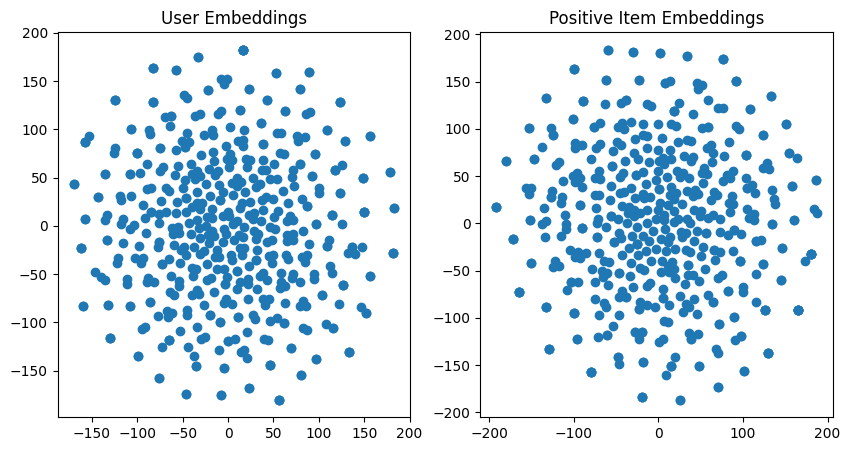

In [42]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE를 사용하여 임베딩을 2차원으로 축소
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
users_emb_2d = tsne.fit_transform(users_emb.detach().numpy())
pos_emb_2d = tsne.fit_transform(pos_emb.detach().numpy())

# 임베딩 시각화
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(users_emb_2d[:, 0], users_emb_2d[:, 1])
plt.title('User Embeddings')
plt.subplot(122)
plt.scatter(pos_emb_2d[:, 0], pos_emb_2d[:, 1])
plt.title('Positive Item Embeddings')
plt.show()


### 🍔만약, adjacency 행렬을 넣었다면 Graph 시각화 가능

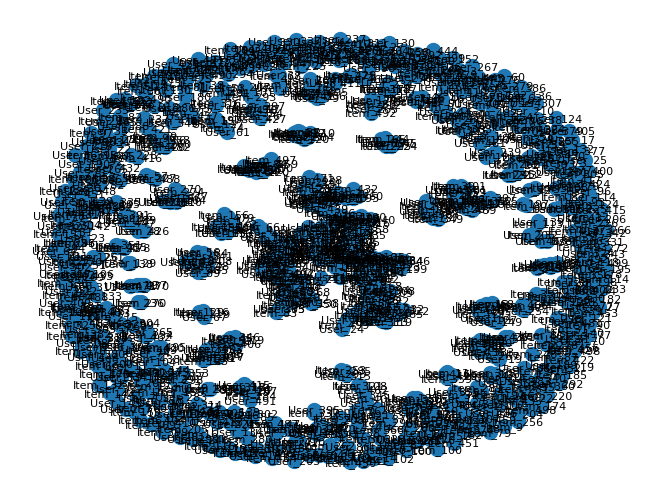

In [43]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

# 사용자와 아이템 임베딩을 NetworkX 그래프로 변환
G = nx.Graph()

# 사용자 임베딩 노드 추가
for user_idx in range(len(users_emb)):
    G.add_node(f'User_{user_idx}', type='user')

# 아이템 임베딩 노드 추가
for item_idx in range(len(pos_emb)):
    G.add_node(f'Item_{item_idx}', type='item')

# 사용자와 아이템 간의 연결 (예: 사용자가 아이템을 평가한 경우)
for user_idx, item_idx in zip(users, pos_items):
    G.add_edge(f'User_{user_idx}', f'Item_{item_idx}', weight=1)

# 그래프 시각화
pos = nx.spring_layout(G, seed=42)  # 레이아웃 설정
nx.draw(G, pos, with_labels=True, node_size=100, font_size=8)

plt.show()
